In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image
import tifffile
import napari
from matplotlib import pyplot as plt
from skvideo import io as skvideo_io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from seghub.classif_utils import get_kmeans_clusters, get_pca_features
from seghub.convpaint_utils import get_convpaint_features_targets_model, get_convpaint_feature_space
from seghub.dino_utils import get_dinov2_patch_features, get_dinov2_pixel_features, get_dinov2_features_targets, get_dinov2_feature_space
from seghub.ilastik_utils import get_ila_features_targets, get_ila_feature_space
from seghub.rf_utils import train_seg_forest, predict_seg_forest_single_image, predict_seg_forest

In [5]:
shark_vid = skvideo_io.vread("../data/shark_test_vid.AVI")
print(shark_vid.shape)

(744, 480, 640, 3)


In [6]:
img = shark_vid[0]
# img = img[:,:,0]
print(img.shape)

(480, 640, 3)


In [7]:
v = napari.view_image(img)

In [8]:
# labels = v.layers['Labels'].data
# tifffile.imsave("../data/shark_vid_labels_frame0.tif", labels.astype(np.uint8))

labels = tifffile.imread("../data/shark_vid_labels_frame0.tif")
v.add_labels(labels)
print(labels.shape)
print(np.sum(labels > 0))

(480, 640)
2480


## Convpaint

In [69]:
feature_space = get_convpaint_feature_space(img, layer_list=[0], scalings=[1,2], model_name="vgg16")
print(feature_space.shape)

(480, 640, 384)


In [44]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space Convpaint")

<Image layer 'Feature Space Convpaint' at 0x1a605c6fc70>

In [70]:
kmeans = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans.shape)

(480, 640)


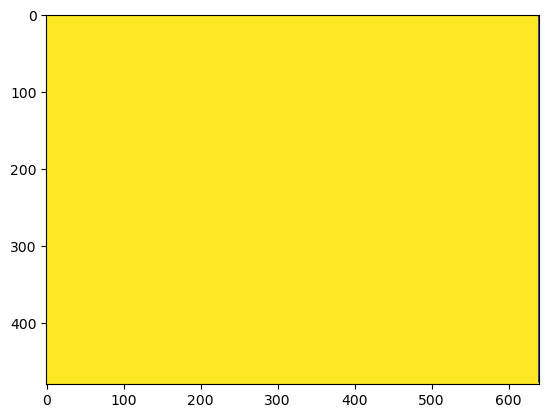

In [71]:
plt.imshow(kmeans)

In [72]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


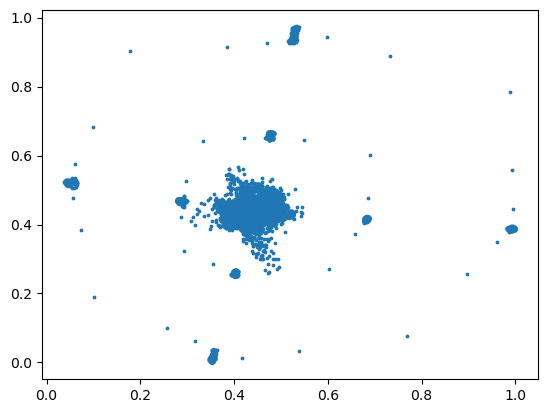

In [73]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [74]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


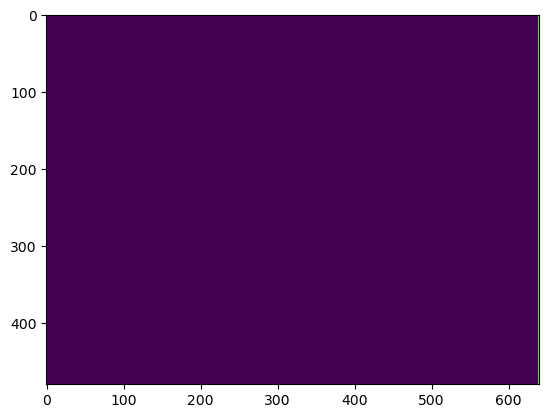

In [75]:
plt.imshow(kmeans_p)

In [76]:
annot_features, targets, model = get_convpaint_features_targets_model(img, labels, layer_list=[0], scalings=[1,2], model_name="vgg16")
print(annot_features.shape)
print(targets.shape)

(2480, 384)
(2480,)


In [77]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


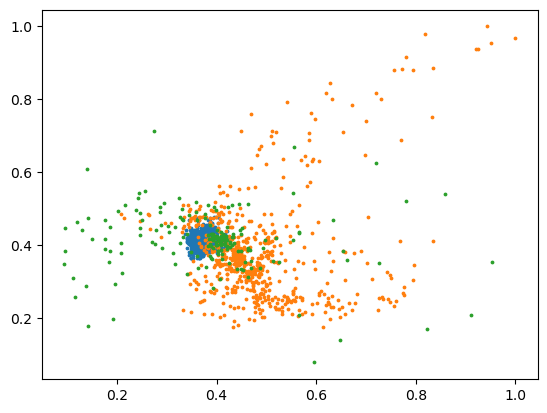

In [78]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## DINOv2

In [79]:
patch_features = get_dinov2_patch_features(img)
print(patch_features.shape)

(1610, 384)


In [80]:
pix_features = get_dinov2_pixel_features(img, interpolate_features=False)
print(pix_features.shape)

(307200, 384)


In [81]:
feature_space = get_dinov2_feature_space(img, interpolate_features=False)
print(feature_space.shape)

(480, 640, 384)


In [57]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space DINOv2")

<Image layer 'Feature Space DINOv2 [1]' at 0x1a619cc8190>

In [82]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


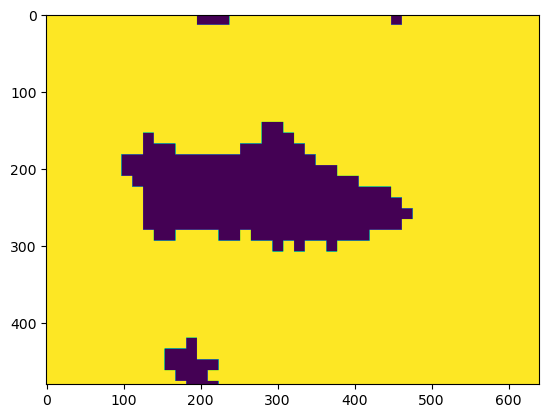

In [83]:
plt.imshow(kmeans_f)

In [86]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 2)


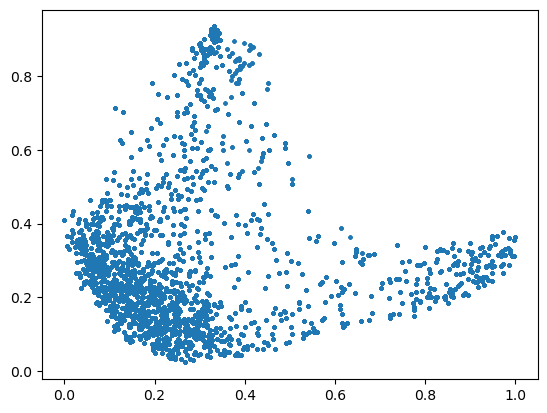

In [88]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [89]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


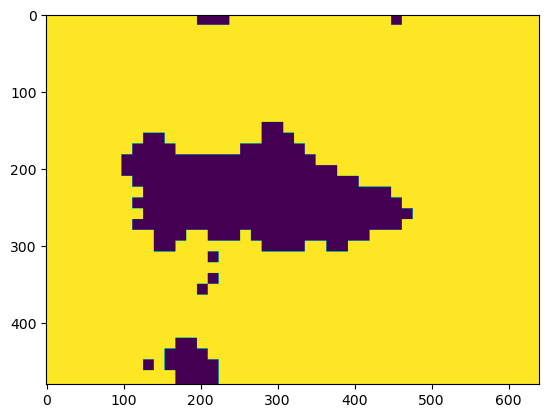

In [90]:
plt.imshow(kmeans_p)

In [91]:
annot_features, targets = get_dinov2_features_targets(img, labels, interpolate_features=False)
print(annot_features.shape)
print(targets.shape)

(2480, 384)
(2480,)


In [92]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


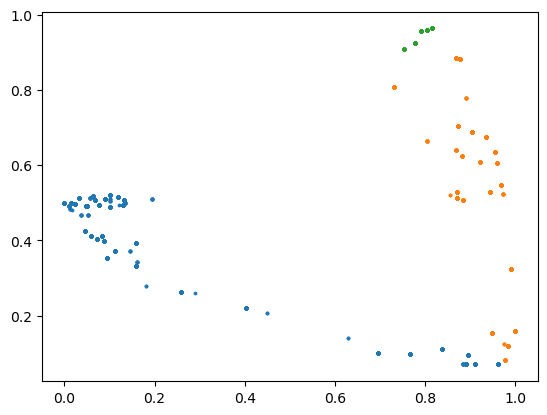

In [93]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Ilastik

In [94]:
feature_space = get_ila_feature_space(img)
print(feature_space.shape)

(480, 640, 168)


In [81]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space Ilastik")

<Image layer 'Feature Space Ilastik' at 0x2202043d880>

In [95]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


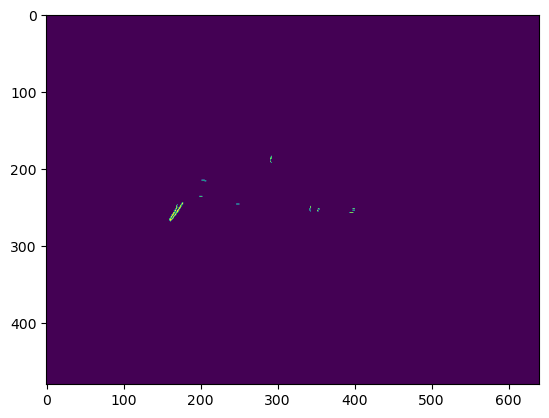

In [96]:
plt.imshow(kmeans_f)

In [97]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 2)


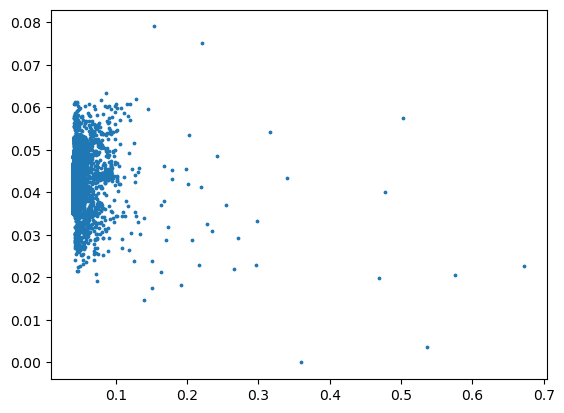

In [98]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [99]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


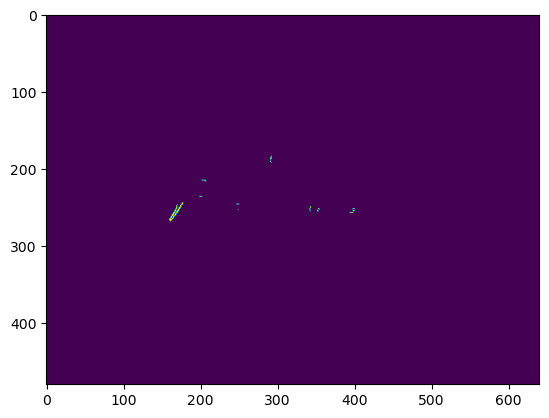

In [100]:
plt.imshow(kmeans_p)

In [101]:
annot_features, targets = get_ila_features_targets(img, labels)

In [102]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


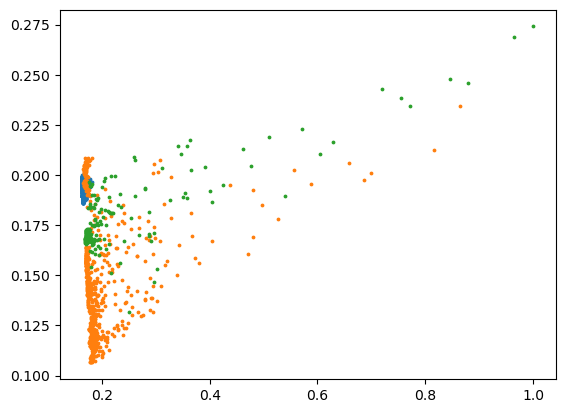

In [103]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Test random forest functions

In [104]:
# features_func_train = get_convpaint_features_targets_model
# features_func_pred = get_convpaint_feature_space
# features_cfg = {"layer_list": [0], "scalings": [1,2], "model_name": "vgg16"}
features_func_train = get_dinov2_features_targets
features_func_pred = get_dinov2_feature_space
# features_func_pred = get_dinov2_pixel_features
# features_func_pred = get_dinov2_patch_features
features_cfg = {"pc": 0}
# features_func_train = get_ila_features_targets
# features_func_pred = get_ila_feature_space
# features_cfg = {}

In [105]:
rf = train_seg_forest([img], [labels], features_func_train, features_cfg, print_steps=True, random_state=0)

Extracting features for labels 1/1 - estimated time left: NA


In [106]:
pred = predict_seg_forest_single_image(img, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14))
print(pred.shape)

(480, 640)


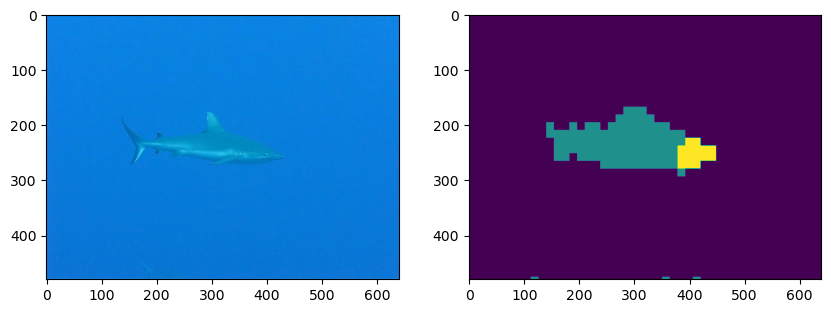

In [107]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(img)
ax[1].imshow(pred)

In [108]:
pred_vid = shark_vid.copy()
pred_vid = pred_vid[:40:4]

In [96]:
v2 = napari.view_image(pred_vid)

In [97]:
pred_batch = predict_seg_forest(pred_vid, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14), print_steps=True)

Predicting image 1/10 - estimated time left: NA
Predicting image 2/10 - estimated time left: 107.7 seconds
Predicting image 3/10 - estimated time left: 80.9 seconds
Predicting image 4/10 - estimated time left: 64.2 seconds
Predicting image 5/10 - estimated time left: 52.1 seconds
Predicting image 6/10 - estimated time left: 42.4 seconds
Predicting image 7/10 - estimated time left: 33.3 seconds
Predicting image 8/10 - estimated time left: 24.6 seconds
Predicting image 9/10 - estimated time left: 16.1 seconds
Predicting image 10/10 - estimated time left: 8.0 seconds


In [98]:
v2.add_labels(pred_batch)

<Labels layer 'pred_batch' at 0x220782b18e0>